### Comparing the addition of trained recognizers for error analysis
Jeyshinee P. Oct 2023

When running an error-analysis on ISIS Ionograms, one of the issues that were flagged was that the metadata being picked up was incorrect. <br> 
More specifically, it was recognizing letters, when there was none. instead of numbers. One fix found was to include a trained recognizer.  <BR>
This notebook showcases the difference. 

In [1]:
# imports 
import sys
import os
import gc
import time
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import keras_ocr
import datetime
import string 
from matplotlib import image as mpimg

In [ ]:
import string

The read_image function is as described below.

In [39]:
def read_image(image_path, plotting=False, just_digits=False):
    '''
    This function reads in one image a time and outputs the height 
    and width along with the estimated digit count of the metadata.
    Parameters:
        image_path (str): path to the image
        plotting (bool, optional): True for a verbose display mode to
                                   illustrate the analysis in detail, 
                                   False otherwise
        just_digits (bool, optional): if True only count characters that are 
                                      integers, False to count any characters

    Returns:

        digit_count (int): estimated number of integers in the ionogram
                          metadata (right now, only looks for numbers along
                          bottom 20% of the image, usually only 15 expected)
                          ~~~~ done for cropped portion of image ~~~~
        height (int): number of pixels along y-axis of original image
        width (int): number of pixels along x-axis of original image
    '''
    try: 

        # read in image using keras_ocr
        image = keras_ocr.tools.read(image_path) 

        # extract height and width of image in pixels 
        height, width = image.shape[0], image.shape[1]
        # cut image to just include bottom 20% of pixels
        cropped_height = height-height//5

        # create predictions for location and value of characters
        # on the cropped image, will output (word, box) tuples
        prediction = pipeline.recognize([image])[0]

        # if no characters are found move on
        if prediction == [[]]:
            digit_count = 0

        # if characters are found look at the predictions
        else:
            if plotting == True:
                # plot the predicted box and tuples
                keras_ocr.tools.drawAnnotations(image=image, predictions=prediction)
                # ADD LINE SHOWING BOTTOM 20% OR JUST CONVERT WHOLE IMAGE
                plt.show()

            # loop over predicted (word, box) tuples and count number of digit characters
            digit_count, max_x, min_x, box_count = 0, -np.inf, np.inf, 0 # CHANGE
            digits = []
            for p in prediction:

                # select word and box part of the tuple
                value, box = p[0], p[1]
                digits.append(value)
                # if word is composed of just integers then 
                # count how many and increment digit_count
                if just_digits == False or (just_digits == True and value.isdigit()): # loop over each digit?
                    # check that box is within the cropped height
                    in_bounds = True           
                    if in_bounds: 
                        box_count +=1 
                        digit_count += len(value)

        print('Digits:', digits)
        print('digits count:', digit_count)
        Total_digits_list.append(digits)


    except Exception as e:
        print('ERR:', e)
        digit_count, height, width= -1, -1, -1

    return digit_count


### Without trained recognizer
Let's look at what keras_ocr picks up before adding the trained recognizer. The base ionogram is added for reference.

In [35]:
pipeline = keras_ocr.pipeline.Pipeline()

Looking for C:\Users\jpyneeandee\.keras-ocr\craft_mlt_25k.h5
Looking for C:\Users\jpyneeandee\.keras-ocr\crnn_kurapan.h5


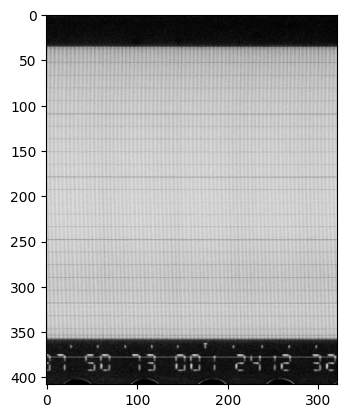

1/1 [==============================] - 2s 2s/step


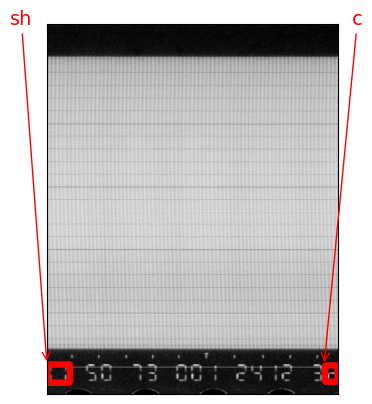

Digits: ['sh', 'c']
digits count: 3


3

In [36]:
img_base = mpimg.imread("L:/DATA/ISIS/ISIS_101300030772/b34_R014207854/B1-35-12 ISIS A C-1876/Image0092.png")
plt.imshow(img_base)
plt.show()
read_image("L:/DATA/ISIS/ISIS_101300030772/b34_R014207854/B1-35-12 ISIS A C-1876/Image0092.png", plotting = True)

We can see that the metadata it picks up is being incorrectly read as sh and c instead of 37 and 2. Let's look at a few more examples:

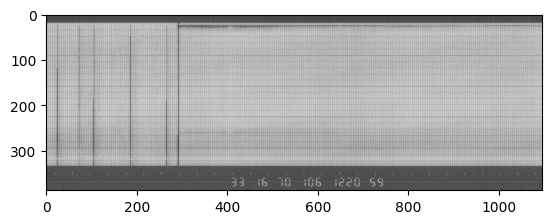

1/1 [==============================] - 0s 383ms/step


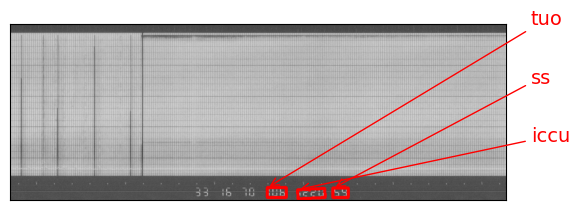

Digits: ['tuo', 'ss', 'iccu']
digits count: 9


9

In [37]:
img_base2 = mpimg.imread("L:/DATA/ISIS/ISIS_101300030772/b25_R014207875/B1-34-62 ISIS A C-998/Image0046.png")
plt.imshow(img_base2)
plt.show()
read_image("L:/DATA/ISIS/ISIS_101300030772/b25_R014207875/B1-34-62 ISIS A C-998/Image0046.png", plotting = True)

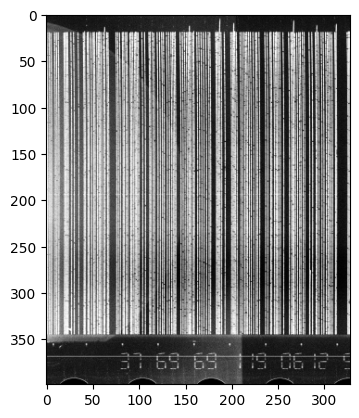

1/1 [==============================] - 0s 321ms/step


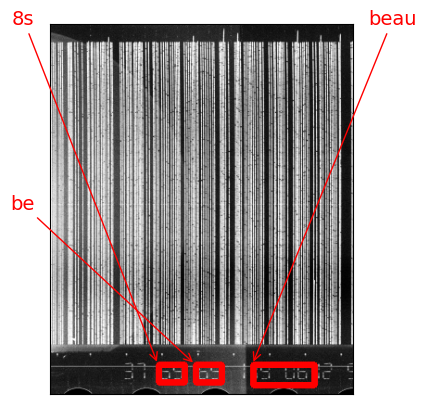

Digits: ['8s', 'be', 'beau']
digits count: 8


8

In [38]:
img_base3 = mpimg.imread("L:/DATA/ISIS/ISIS_101300030772/b7_R014207896/B1-34-50 ISIS A C-260/Image0196.png")
plt.imshow(img_base3)
plt.show()
read_image("L:/DATA/ISIS/ISIS_101300030772/b7_R014207896/B1-34-50 ISIS A C-260/Image0196.png", plotting = True)


### Testing on a randomly chosen subdirectory 
We randomly choose a subdirectory and then randomly sample 100 images from that subdirectory. <br>
Sample size = 100

In [40]:
path = "L:/DATA/ISIS/ISIS_101300030772/b7_R014207896/B1-34-50 ISIS A C-260"
image_list = []
for root, dirs, files in os.walk(path):
    for file in files:
            image_list.append(os.path.join(root,file))  

In [44]:
new_sample_set = np.random.choice(image_list, 100,False) #random sample of 100 images

In [89]:
os.chdir("C:/Users/jpyneeandee/Documents") #saving images for reproducibility
i = 0
for image in new_sample_set:
    mpimg.imread(image)
    plt.savefig("Picture" +str(i))
    i = i + 1


<Figure size 640x480 with 0 Axes>

In [ ]:
for image in new_sample_set:
    read_image(image)
Total_digits_list   

Let's get a count of how many letters were picked up:

In [123]:
letters_count = 0
letters_count_list = []
num_count = 0
for list_in in Original_list:
    for item in list_in:
        if item.isalpha(): #check if any item contains the alphabet
            letters_count_list.append(item)
print(len(letters_count_list))

410


## Adding trained recognizer
Let's now add the trained recognizer and look at the difference.

In [50]:
recognizer = keras_ocr.recognition.Recognizer(alphabet= string.digits) 
recognizer.model.load_weights('L:/DATA/ISIS/keras_ocr_training/ISIS_reading.h5')   
recognizer.compile()  
pipeline = keras_ocr.pipeline.Pipeline(recognizer=recognizer)

Provided alphabet does not match pretrained alphabet. Using backbone weights only.
Looking for C:\Users\jpyneeandee\.keras-ocr\crnn_kurapan_notop.h5
Looking for C:\Users\jpyneeandee\.keras-ocr\craft_mlt_25k.h5


1/1 [==============================] - 3s 3s/step


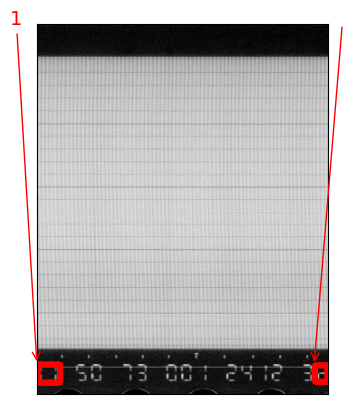

digits count: 1
1/1 [==============================] - 0s 271ms/step


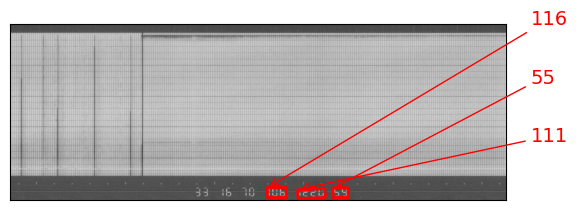

digits count: 8
1/1 [==============================] - 0s 390ms/step


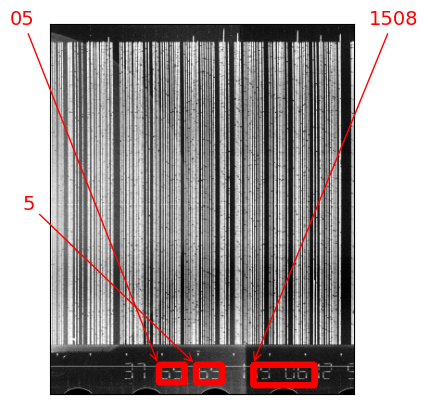

digits count: 7


(7, 399, 328)

In [19]:
read_image("L:/DATA/ISIS/ISIS_101300030772/b34_R014207854/B1-35-12 ISIS A C-1876/Image0092.png", plotting = True)
read_image("L:/DATA/ISIS/ISIS_101300030772/b25_R014207875/B1-34-62 ISIS A C-998/Image0046.png", plotting = True)
read_image("L:/DATA/ISIS/ISIS_101300030772/b7_R014207896/B1-34-50 ISIS A C-260/Image0196.png", plotting = True)

And we now test the same sample set from above, using the trained recognizer:

In [ ]:
Total_digits_list = []
for image in new_sample_set:
    read_image(image)

Let's check if any letters were read by the trained recognizer.

In [124]:
letters_count = 0
letters_count_list = []
num_count = 0
for list_in in Total_digits_list:
    for item in list_in:
        if item.isalpha(): #check if any item contains the alphabet
            letters_count_list.append(item)
print(len(letters_count_list))

0


In [90]:
Total_digits_list  

[['5', '65', '111'],
 ['32', '120', '05', '65', '111'],
 ['32', '1122', '65', '65', '121'],
 [],
 ['5', '1'],
 ['05', '16', '05', '115', '11'],
 ['65', '65'],
 ['5', '5'],
 ['05', '05'],
 ['121', '32', '5', '65', '0353', '111'],
 ['5', '5', '65', '1211', ''],
 ['05', '5', '1711', '5', '111'],
 ['14'],
 ['6', '65', '1111', '1155', ''],
 [],
 ['65', '65', '1211', '32', '0558'],
 [],
 ['65', '65', '115', '115', '11'],
 ['69', '11', '65'],
 ['4', '17', '8'],
 ['',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '1',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '5',
  '111',
  '1331',
  '7'],
 ['65', '11111